# Here be scripts for generating the figures in our cell labelling paper.

In [1]:
# It's dangerous to go alone, take these
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ranksums
from scipy.stats import mode, wilcoxon, ranksums, spearmanr, pearsonr
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from os import listdir

%matplotlib inline

clustlist = ['GSEA', 'GSVA','ORA','MetaNeighbor','Adobo','scCATCH','CIBERSORT']
clustnames = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
celllist =  ['LAmbDA',
             'Cell_BLAST',
             'RF',
             'kNN9',
             'ACTINN',
             'LDA',
             'LDArej',
             'CaSTLe',
             'scmapcluster',
             'SVM',
             'SingleCellNet',
             'scVI',
             'SVMrej',
             'scmapcell',
             'NMC',
             'singleR',
             'scID',
             'scPred',
             'CHETAH',
            ]

alg_rename = {key:item for key,item in zip(clustnames+celllist,clustlist+celllist)}
print(alg_rename)
dataset_rename = {'cb':'Breast',
                  'dg': 'Glioblastoma',
                  'jam': 'Melanoma',
                  'li_crc': 'Colorectal',
                  'llc': 'Lung',
                  'peng': 'Pancreatic',
                  'tm':'Metastatic Melanoma',
                  'vg':'AML',
                 }

def make_heatmap(infile, outfile, title, column, show_data=False):
    #read the result and set the index.
    result = pd.read_csv(infile, sep='\t')
    result
    hbs = result.reset_index()
    hbs.drop('index',axis=1, inplace=True)
    hbs.dataset = hbs.apply(lambda row: dataset_rename[row['dataset']], axis=1)
    hbs.algorithm = hbs.apply(lambda row: alg_rename[row['algorithm']], axis=1)
    
    #display the file if you want to make sure that it's loaded correctly
    if show_data:
        display(hbs)
    
    datasets = list(set(hbs.dataset))
    #set the order of the datasets for the axis
    datasets = ['Colorectal', 'Breast', 'Glioblastoma','Metastatic Melanoma','Melanoma','AML','Lung','Pancreatic']
    methods = list(set(hbs.algorithm))
    
    # Make a dataframe of average f-measure for datasets and methods
    hmdf = pd.DataFrame(columns=datasets)
    for method in methods:
        #select only the rows for the current method and add them to the heatmap dataframe
        tempdf = hbs[hbs.algorithm == method].copy()
        datalist = []
        for dataset in datasets:
            datalist.append(tempdf[tempdf.dataset==dataset][column].mean())
        dataseries = pd.Series(datalist, index = hmdf.columns)
        hmdf = hmdf.append(dataseries,ignore_index=True)
    
    hmdf.index = methods
    
    #make a column of average values, sort by  that column, then save it in another variable and remove it.
    hmdf['avg'] = hmdf.apply(lambda row: row.median(), axis=1) #MEDIAN INSTEAD OF MEAN
    # sort by average and define a colourmap
    hmdf.sort_values(by='avg',ascending=False, inplace=True)
    colour = sns.color_palette("Greens",as_cmap=True)
    avg_hm = hmdf[['avg']].copy()
    hmdf=hmdf[datasets]
   
    #set up the matplotlib object with 1 row and two columns of unequal width
    fig, (ax1, ax2) = plt.subplots(1,2,dpi=100,gridspec_kw={'width_ratios': [1, 10]})
    
    # create heatmaps, rightplot is all the datasets, leftplot is the avg bar
    rightplot = sns.heatmap(hmdf, vmin=0, vmax=1, annot=True, cmap=colour, ax=ax2, yticklabels=False)
    leftplot = sns.heatmap(avg_hm, vmin=0, vmax=1, annot=True, cmap=colour, ax=ax1, cbar=False, yticklabels=True)
    #set the facecolour for NA values, angle the x axis tick labels
    rightplot.set_facecolor('silver')
    leftplot.set_facecolor('silver')
    rightplot.set_xticklabels(rightplot.get_xticklabels(),
                              rotation=45,
                              horizontalalignment='right')
    leftplot.set_xticklabels(['Median'],
                             rotation=45,
                             horizontalalignment='right')
    fig.set_figheight(10)
    fig.set_figwidth(8)
    #change the colour of the tick labels for cluster based algorithms
    for i in leftplot.get_yticklabels():
        if i.get_text() in clustlist:
            i.set_color('brown')
    plt.gca().set_title(title)
    plt.savefig(outfile, bbox_inches = 'tight', dpi=500)

{'gsea': 'GSEA', 'gsva': 'GSVA', 'ora': 'ORA', 'metaneighbor': 'MetaNeighbor', 'adobo': 'Adobo', 'sccatch': 'scCATCH', 'cibersort': 'CIBERSORT', 'LAmbDA': 'LAmbDA', 'Cell_BLAST': 'Cell_BLAST', 'RF': 'RF', 'kNN9': 'kNN9', 'ACTINN': 'ACTINN', 'LDA': 'LDA', 'LDArej': 'LDArej', 'CaSTLe': 'CaSTLe', 'scmapcluster': 'scmapcluster', 'SVM': 'SVM', 'SingleCellNet': 'SingleCellNet', 'scVI': 'scVI', 'SVMrej': 'SVMrej', 'scmapcell': 'scmapcell', 'NMC': 'NMC', 'singleR': 'singleR', 'scID': 'scID', 'scPred': 'scPred', 'CHETAH': 'CHETAH'}


# Figure 1

,Chung (Breast),Darmanis (Glioblastoma),Jerby Arnon (Melanoma),Li (Colorectal),Lambrechts (Lung),Peng (Pancreatic),Tirosh (Metastatic Melanoma),Van Galen (AML)
Cells,515,3589,6879,359,51775,57530,4645,21933
Genes,57915,23465,23686,57241,22533,24005,23686,27899
Cell Types,5,7,9,5,17,10,7,6
Technology,Fluidigm C1,SMART-seq2,SMART-seq2,Fluidigm C1,10x Genomics,10x Genomics,SMART-seq2,Seq-Well


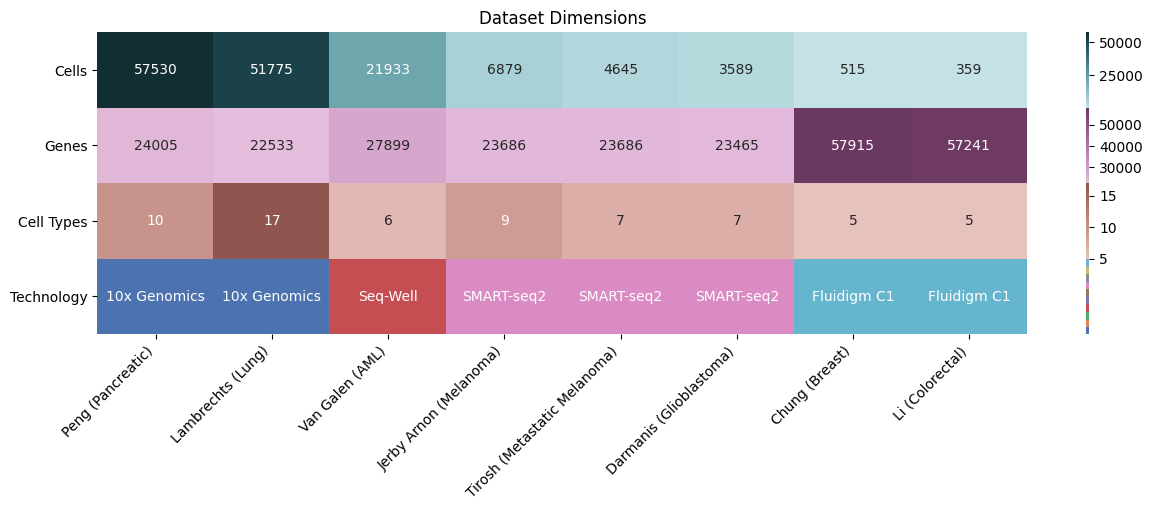

In [2]:
#read the file
ds = pd.read_csv("data_sizes.tsv", sep='\t',index_col=0)
display(ds)
#force the order on the x axis
ds = ds[['Peng (Pancreatic)', 
         'Lambrechts (Lung)', 
         'Van Galen (AML)', 
         'Jerby Arnon (Melanoma)', 
         'Tirosh (Metastatic Melanoma)', 
         'Darmanis (Glioblastoma)', 
         'Chung (Breast)',
         'Li (Colorectal)']]

#make a 3 row x 1 column subplot
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1,dpi=100)
#first heatmap, number of cells
cellplot = sns.heatmap(ds.drop(["Genes","Cell Types","Technology"]).astype(int), 
                       annot=True, ax=ax1, xticklabels=False,
                       yticklabels=True,fmt="g",
                       cmap=sns.cubehelix_palette(start=-.5, 
                           rot=0, 
                           dark=0.15, 
                           light=.85, 
                           reverse=False, 
                           as_cmap=True
                           )
                       )
#second heatmap, number of genes
geneplot = sns.heatmap(ds.drop(["Cells","Cell Types","Technology"]).astype(int), 
                       annot=True, ax=ax2, xticklabels=False,fmt="g",
                       cmap=sns.cubehelix_palette(start=.5, 
                           rot=0, 
                           dark=0.3, 
                           light=.8, 
                           reverse=False, 
                           as_cmap=True
                           )
                       )
#third heatmap, number of cell types
typeplot = sns.heatmap(ds.drop(["Genes","Cells","Technology"]).astype(int), 
                       annot=True, ax=ax3, xticklabels=False, fmt="g",
                       cmap=sns.cubehelix_palette(start=1, 
                           rot=0, 
                           dark=0.4, 
                           light=.8, 
                           reverse=False, 
                           as_cmap=True
                           )
                       )
value_to_int = {j:i for i,j in enumerate(pd.unique(ds.values.ravel()))}
techplot = sns.heatmap(ds.drop(["Genes","Cells","Cell Types"]).replace(value_to_int), 
                       annot=ds.drop(["Genes","Cells","Cell Types"]), fmt="",
                       ax=ax4, xticklabels=True,cmap=sns.color_palette("deep"),
                       cbar_kws={"ticks":[]}
                       )
#force the yticklabels to be horizontal
cellplot.set_yticklabels(cellplot.get_yticklabels(),rotation=0)
geneplot.set_yticklabels(geneplot.get_yticklabels(),rotation=0)
typeplot.set_yticklabels(typeplot.get_yticklabels(),rotation=0)
techplot.set_yticklabels(techplot.get_yticklabels(),rotation=0)

#rotate the xticklabels 45 degrees
techplot.set_xticklabels(techplot.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.set_figwidth(15)
cellplot.set_title("Dataset Dimensions")

#remove the space between the subplots
plt.subplots_adjust(hspace=0)
plt.savefig("plots/Figure_1/data_sizes.png", dpi=500,bbox_inches="tight")

# Figure 2

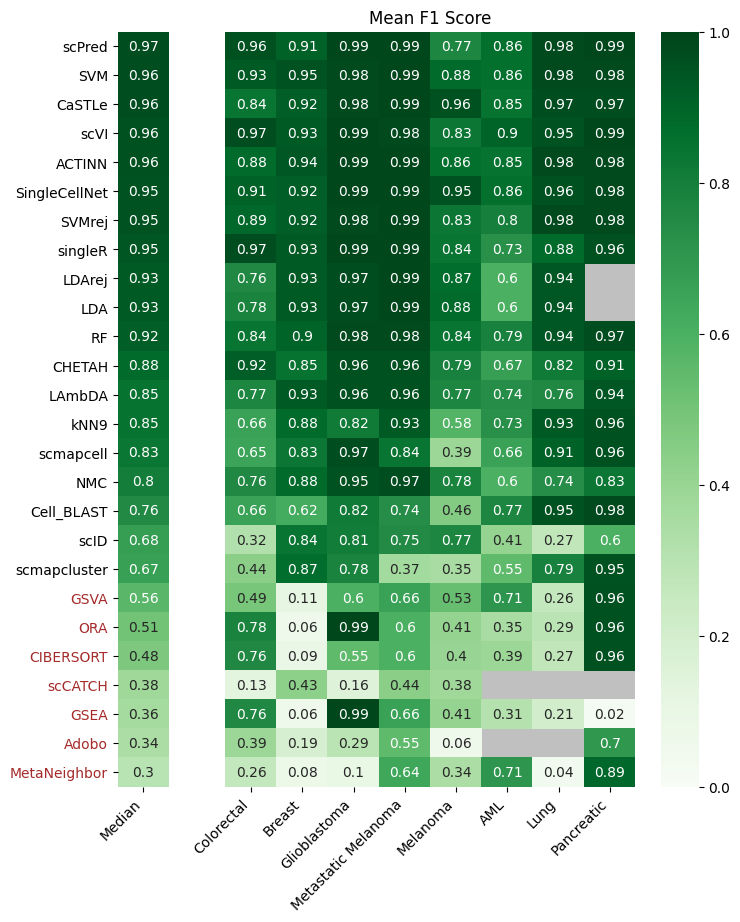

In [3]:
make_heatmap('Rdata/F-Measure-Bootstrap-Ensemble.tsv', 'plots/Figure_2/fm_heatmap.png', 'Mean F1 Score', 'F.Mean')

In [4]:
hmdf = pd.read_csv('./times/df_for_heatmap.tsv',sep='\t', index_col=0)
#these values are in log scale, and we'll use this for the colours
#switch back to seconds to make the text for the cells.
def get_seconds(x):
    if np.isnan(x):
        return x
    else:
        return int(np.exp(x)-1)
hmdf_labels = hmdf.applymap(get_seconds) #normal seconds as labels

methods = list(set(hmdf.index))
#make a column of average values, sort by  that column, then save it in another variable and remove it.
hmdf['median'] = hmdf.apply(lambda row: row.median(), axis=1)
hmdf_labels['median'] = hmdf_labels.apply(lambda row: row.median(), axis=1)

avg_hm = hmdf[['median']].copy()
avg_hm_labels = hmdf_labels[['median']].copy()
hmdf = hmdf.drop(columns='median')
hmdf_labels = hmdf_labels.drop(columns='median')

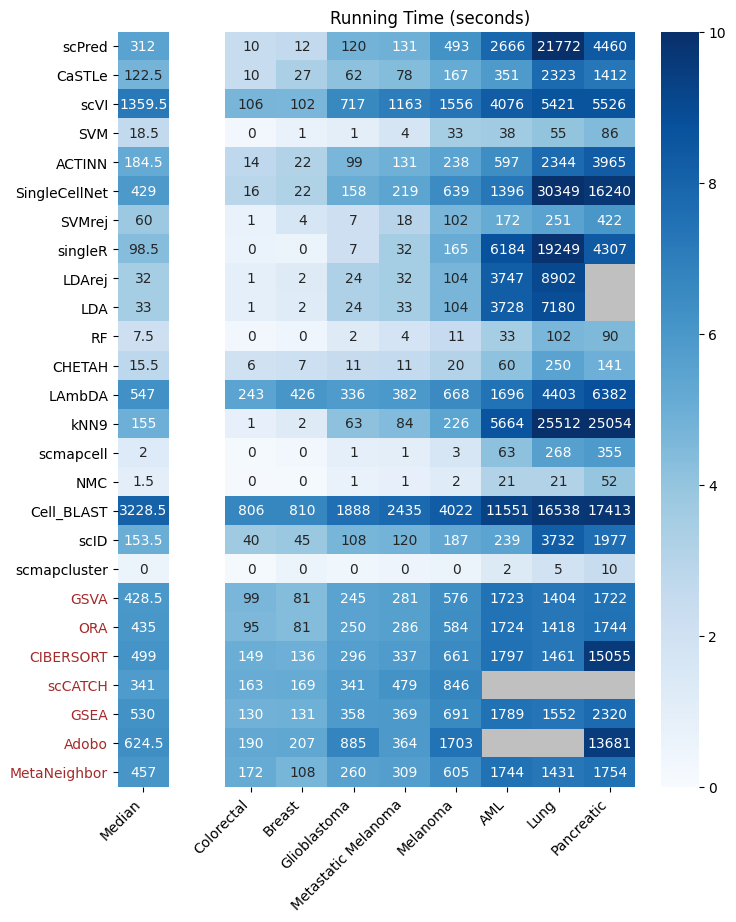

In [6]:
colour = sns.color_palette("Blues",as_cmap=True)
fig, (ax1, ax2) = plt.subplots(1,2,dpi=100,gridspec_kw={'width_ratios': [1, 10]})

# create heatmaps, rightplot is all the datasets, leftplot is the median bar
rightplot = sns.heatmap(hmdf, vmin=0, vmax=10, annot=hmdf_labels,fmt="g",cmap=colour, ax=ax2, yticklabels=False)
leftplot = sns.heatmap(avg_hm, vmin=0, vmax=10, annot=avg_hm_labels,fmt="g", cmap=colour, ax=ax1, cbar=False, yticklabels=True)
rightplot.set_facecolor('silver')
leftplot.set_facecolor('silver')
rightplot.set_xticklabels(rightplot.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
leftplot.set_xticklabels(['Median'],
                         rotation=45,
                         horizontalalignment='right')
fig.set_figheight(10)
fig.set_figwidth(8)
for i in leftplot.get_yticklabels():
    if i.get_text() in clustlist:
        i.set_color('brown')
plt.gca().set_title('Running Time (seconds)')
plt.savefig('./plots/Figure_2/time_heatmap.png', bbox_inches = 'tight', dpi=500)

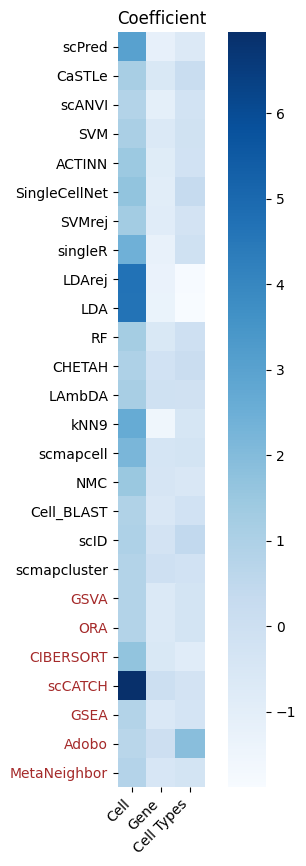

In [7]:
hmdf = pd.read_csv('./times/df_coef.tsv',sep='\t', index_col=0)
colour = sns.color_palette("Blues",as_cmap=True)
fig, ax1 = plt.subplots(1,1,dpi=100)

# create heatmaps, rightplot is all the datasets, leftplot is the median bar
rightplot = sns.heatmap(hmdf, 
                        #vmin=0, vmax=10,
                        fmt="g",cmap=colour, ax=ax1, yticklabels=True,square=True)
rightplot.set_facecolor('silver')
rightplot.set_xticklabels(rightplot.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
fig.set_figheight(10)
#fig.set_figwidth(4)
for i in rightplot.get_yticklabels():
    if i.get_text() in clustlist:
        i.set_color('brown')
plt.gca().set_title('Coefficient')
plt.savefig('./plots/Figure_2/time_coefs.png', bbox_inches = 'tight', dpi=500)

In [2]:
# Read in the performance measures
bigdf = pd.read_csv("performance/seurat/bigdf.tsv", sep='\t')
#rename the malignant category, and remove unknown/unavailable labels
bigdf['category'] = bigdf.apply(lambda row: 'Malignant' if row['category']=='Tumour'\
                                  else row['category'], axis=1)
bigdf = bigdf[bigdf['class'] != 'UNLABELED']
bigdf = bigdf[bigdf['class'] != 'UNAVAILABLE']

In [3]:
categories = list(set(bigdf.category))
methods = list(set(bigdf.method))

datasets = list(set(bigdf.dataset))
median_hm = pd.DataFrame()
median_hm['category'] = categories
median_hm.set_index('category', inplace=True)
bigdf = bigdf.sort_values(by='support',ascending=False)

# Make a dataframe of average f-measure for datasets and methods
for dataset in datasets:
    hmdf = pd.DataFrame(columns=categories)
    tempdf = bigdf[bigdf.dataset == dataset].copy()
    for method in methods:
        mdf = tempdf[tempdf.method==method].copy()
        datalist = []
        for category in categories:
            #if category == 'Vascular':
                #display(mdf[mdf.category==category])
            datalist.append(mdf[mdf.category==category]['f1_score'].mean())
        dataseries = pd.Series(datalist, index = hmdf.columns)
        hmdf = hmdf.append(dataseries,ignore_index=True)

    hmdf.index = methods
    hmdf = hmdf.dropna(axis=1, how='all')
    if dataset == 'vg':
        hmdf = hmdf.dropna(axis=0)
    hmdf = hmdf.T
    
    #make a column of average values, sort by  that column, then save it in another variable and remove it.
    hmdf['avg'] = hmdf.apply(lambda row: row.median(), axis=1)
    hmdf.sort_values(by='avg',ascending=False, inplace=True)
    avg_hm = hmdf[['avg']].copy()
    colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
    colour = sns.color_palette("Greens",as_cmap=True)
    median_hm[dataset] = avg_hm['avg']

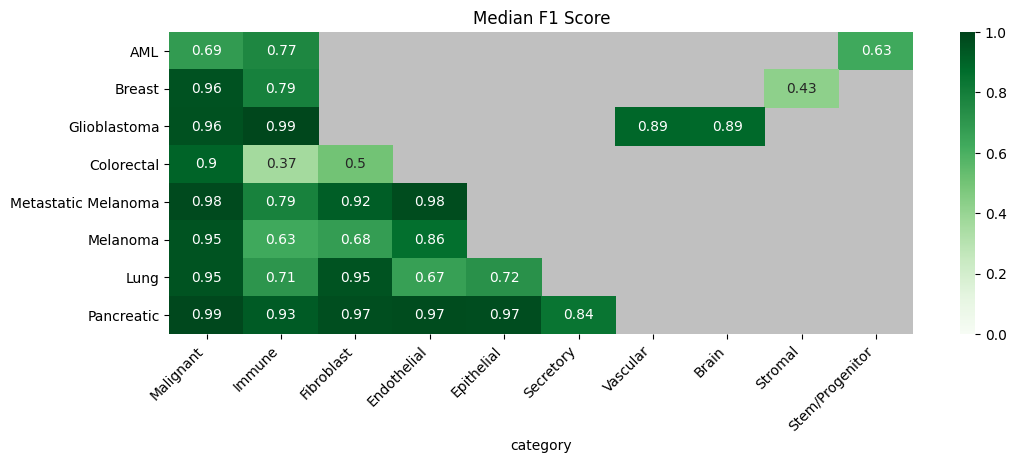

In [10]:
fig, (ax1) = plt.subplots(1,1,dpi=100)
mhmt = median_hm.T
mhmt = mhmt[['Malignant',
             'Immune',
             'Fibroblast', 
             'Endothelial',
             'Epithelial',
             'Secretory',
             'Vascular',
             'Brain',
             'Stromal',
             'Stem/Progenitor',
             ]]
index_list = ['Pancreatic', 'Lung','Melanoma','Metastatic Melanoma','Colorectal','Glioblastoma','Breast','AML']
index_list = index_list[::-1]
mhmt = mhmt.reindex(index_list)
plot = sns.heatmap(mhmt, vmin=0, vmax=1, annot=True, cmap=colour, ax=ax1)
plot.set_facecolor('silver')
plot.set_xticklabels(plot.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right')
fig.set_figwidth(12)
plt.gca().set_title("Median F1 Score")
plt.savefig("plots/Figure_4/median_dataset_v_category.png",bbox_inches='tight', dpi=500, transparent=False)

/usr/local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,avg,nm_avg,algtype,V2
LAmbDA,0.954486,0.776411,Cell Based,-0.178076
singleR,0.969717,0.892420,Cell Based,-0.077297
NMC,0.858263,0.761097,Cell Based,-0.097167
kNN9,0.953681,0.685197,Cell Based,-0.268484
scmapcell,0.954858,0.481058,Cell Based,-0.473799
LDArej,0.965486,0.790960,Cell Based,-0.174525
LDA,0.965486,0.846257,Cell Based,-0.119228
gsva,0.252093,0.607845,Cluster Based,0.355752
CHETAH,0.902564,0.827806,Cell Based,-0.074758
scVI,0.990094,0.900801,Cell Based,-0.089293


p =  0.016439723926508207


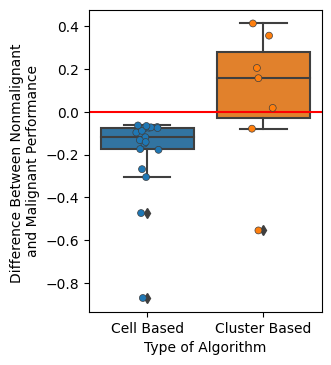

In [6]:
bigdf = pd.read_csv("performance/seurat/bigdf.tsv", sep='\t')
bigdf['category'] = bigdf.apply(lambda row: 'Malignant' if row['category']=='Tumour'\
                                  else row['category'], axis=1)
maligdf = bigdf[bigdf['category']=='Malignant'].copy()
bigdf = bigdf[bigdf['category']!='Malignant'].copy()
datasets = list(set(maligdf.dataset))
methods = list(set(maligdf['method']))
hmdf = pd.DataFrame(columns=datasets)
for method in methods:
    tempdf = maligdf[maligdf.method == method].copy()
    #display(tempdf)
    datalist = []
    for dataset in datasets:
        datalist.append(tempdf[tempdf.dataset==dataset]['f1_score'].mean())
    dataseries = pd.Series(datalist, index = hmdf.columns)
    hmdf = hmdf.append(dataseries,ignore_index=True)

hmdf.index = methods

#make a column of average values, sort by  that column, then save it in another variable and remove it.
hmdf['avg'] = hmdf.apply(lambda row: row.median(), axis=1) #MEDIAN INSTEAD OF MEAN
#hmdf.sort_values(by='avg',ascending=False, inplace=True)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
avg_hm = hmdf[['avg']].copy()

hmdf2 = pd.DataFrame(columns=datasets)
datasets = list(set(bigdf.dataset))
methods = list(set(bigdf['method']))
for method in methods:
    tempdf = bigdf[bigdf.method == method].copy()
    datalist = []
    for dataset in datasets:
        #datalist.append(tempdf[tempdf.dataset==dataset]['f1_score'].mean())
        datalist.append(tempdf[tempdf.dataset==dataset]['f1_score'].median())
    dataseries = pd.Series(datalist, index = hmdf2.columns)
    hmdf2 = hmdf2.append(dataseries,ignore_index=True)

hmdf2.index = methods

#make a column of average values, sort by  that column, then save it in another variable and remove it.
#hmdf2['avg'] = hmdf2.apply(lambda row: row.mean(), axis=1)
hmdf2['avg'] = hmdf2.apply(lambda row: row.median(), axis=1) #MEDIAN INSTEAD OF MEAN
#hmdf2.sort_values(by='avg',ascending=False, inplace=True)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
avg_hm2 = hmdf2[['avg']].copy()
avg_hm['nm_avg'] = avg_hm2['avg'].copy()
avg_hm['algtype'] = "cluster"
avg_hm.loc[celllist,'algtype'] = 'cell'
avg_hm['V2'] = (avg_hm['nm_avg']-avg_hm['avg'])
avg_hm['algtype'] = avg_hm.apply(lambda row: 'Cluster Based' if row.name in clustnames else 'Cell Based', axis=1)
display(avg_hm)
x =  avg_hm[avg_hm['algtype']=='Cell Based']['V2']
y =  avg_hm[avg_hm['algtype']=='Cluster Based']['V2']
stat,pval = ranksums(x,y)
print('p = ',pval)
fig, ax = plt.subplots(dpi=100)
bx = sns.boxplot(y='V2', x='algtype', data=avg_hm,ax=ax)

sns.stripplot(y='V2', x='algtype', data=avg_hm, linewidth=0.5,ax = ax)
bx.set_ylabel("Difference Between Nonmalignant \nand Malignant Performance")
bx.set_xlabel("Type of Algorithm")
plt.axhline(0,color='r')
fig.set_figheight(4)
fig.set_figwidth(3)
plt.savefig("./plots/Figure_4/nm_m_difference_box.png", dpi=500, bbox_inches="tight")
plt.show()

10
['Malignant', 'Secretory', 'Stromal', 'Endothelial', 'Vascular', 'Stem/Progenitor', 'Fibroblast', 'Brain', 'Epithelial', 'Immune']


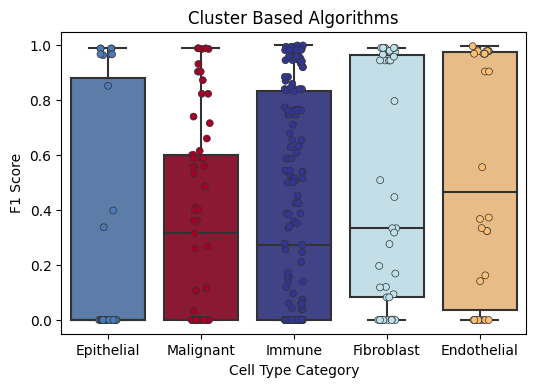

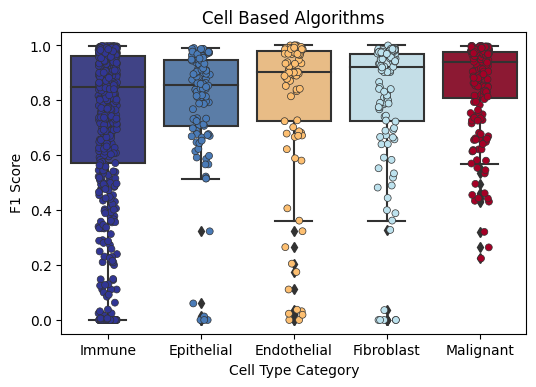

In [14]:
bigdf = pd.read_csv("performance/seurat/bigdf.tsv", sep='\t')
bigdf = bigdf.sort_values('support',axis=0)
bigdf = bigdf.dropna()

bigdf['category'] = bigdf.apply(lambda row: 'Malignant' if row['category']=='Tumour'\
                                  else row['category'], axis=1)
auto_catlist = list(set(bigdf['category']))
catlist = ['Malignant', 
           
           'Secretory', 
           'Stromal', 
           
           'Endothelial', 
           
           'Vascular', 
           'Stem/Progenitor', 
           
           'Fibroblast', 
           
           'Brain', 
           'Epithelial', 
           
           'Immune', 
          ]
if len(auto_catlist) != len(catlist):
    print("Error! Manual category list has incorrect categories.")
n_cats = len(catlist)
print(n_cats)
# name is one of these: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# gets n_cats colours from a named colourmap. If using a qualitative colourmap, 
    # make sure it has >=n_cats colours
mcmap = plt.cm.get_cmap('RdYlBu',n_cats)
colour_dict = {catlist[i]:mcmap(i) for i in range(n_cats)}
bigdf['colour'] = bigdf.apply(lambda row: colour_dict[row['category']],axis=1)
coldf = bigdf[['class','category','colour']].copy().drop_duplicates('class')
my_palette = pd.Series(coldf['colour'].values,index=coldf['class']).to_dict()
print(catlist)

#confirm that the palette contains enough unique colours
if len(pd.Series(colour_dict.values()).unique()) < n_cats:
    print("Not enough colours!!")


categorylist = ['Malignant', 'Immune','Fibroblast','Endothelial','Epithelial']
clustlist = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
bigdf['algtype'] = bigdf.apply(lambda row: 'cluster' if row['method'] in clustlist else 'cell', axis=1)
tempdf =bigdf[(bigdf['method'].isin(clustlist))&(bigdf['category'].isin(categorylist))].copy()
boxorder = tempdf.groupby('category').median().sort_values('f1_score').index
cluster_boxorder = tempdf.groupby('category').mean().sort_values('f1_score').index

fig, ax = plt.subplots(1,1, dpi=100)
saturation_factor = 0.7
bx = sns.boxplot(x='category', 
                 y='f1_score', 
                 data=tempdf,
                 ax=ax,
                 order = cluster_boxorder,
                 palette=colour_dict,
                 saturation=saturation_factor
                    )
bxplt = sns.stripplot(x='category', 
                    y='f1_score', 
                    data=tempdf,
                    ax=ax,
                    order = cluster_boxorder,
                      linewidth=.5,
                    palette=colour_dict
                    )
plt.title("Cluster Based Algorithms")
bxplt.set_xlabel('Cell Type Category')
bxplt.set_ylabel('F1 Score')
plt.savefig('./plots/Figure_4/top_four_cats_cluster_boxstrip.png', dpi=300, bbox_inches='tight')
plt.show()
tempdf =bigdf[(bigdf['method'].isin(celllist))&(bigdf['category'].isin(categorylist))].copy()
boxorder = tempdf.groupby('category').median().sort_values('f1_score').index
fig, ax = plt.subplots(1,1, dpi=100)
bx = sns.boxplot(x='category', 
                 y='f1_score', 
                 data=tempdf,
                 ax=ax,
                 order = boxorder,
                 palette=colour_dict,
                 saturation=saturation_factor
                 )
bxplt = sns.stripplot(x='category', 
                    y='f1_score', 
                    data=tempdf,
                    ax=ax,
                    order = boxorder,
                      linewidth=.5,
                    palette=colour_dict
                    )
plt.title("Cell Based Algorithms")
bxplt.set_xlabel('Cell Type Category')
bxplt.set_ylabel('F1 Score')
plt.savefig('./plots/Figure_4/top_four_cats_cell_boxstrip.png', dpi=300, bbox_inches='tight')
plt.show()